In [2]:
from create_model import get_model
from dataset import load_data
from train_model import collate_fn
from visualization import drawrect
from torchvision.ops import nms
from transformations import get_transformation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
%load_ext autoreload
%autoreload 2

In [ ]:
# Load Model
model = get_model("fasterrcnn", num_classes=4, trainable_backbone_layers=1)
model_path = "G:/My Drive/ACV Project/m_v3_50e.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()

In [7]:
# Load dataset
dataset_path = "./../../NBA-Player-Detector-1"
tdict = {}
tdict['one_of_probability'] = 1 # prob of using one of the transformations below
tdict['brightness_contrast'] = 1
transformation = get_transformation(tdict)
trainset, valset, testset = load_data(dataset_path, train_transform=transformation)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=2, 
                                          shuffle=False, 
                                          num_workers=1, 
                                          drop_last=False,
                                          collate_fn = collate_fn)

In [8]:
CLASS_COLORS = {
    1 : (255,0,0),
    2 : (0,255,0),
    3 : (0,0,255)
}

def draw_gt_pred_boxes(image: torch.Tensor, gt: torch.Tensor, pred: torch.Tensor, MIN_PRED_SCORE=0.5):
    """

    Args:
        image (torch.Tensor): torch.float32 shape (C x H x W)
        gt (torch.Tensor): dictionary containing:
            - 'boxes'  -> Tensor of shape (N, 4)
            - 'labels' -> Tensor of shape (N, ) with ints
        pred (torch.Tensor): dictionary containing:
            - 'boxes'  -> Tensor of shape (M, 4)
            - 'labels' -> Tensor of shape (M, ) with ints
            - 'scores' -> Tensor of shape (M, ) with floats
    """

    assert image.dtype == torch.float32
    assert type(gt) == dict
    if pred is not None:
        assert type(pred) == dict

    # Transform image to numpy array of ints and shape (H,W,C)
    vis_image = (image * 255).to(torch.uint8)
    vis_image = vis_image.permute(1,2,0).numpy()

    # Define the list of gt and pred to process
    # TODO check if to apply NMS here
    
    # Predicted boxes
    if pred is not None:
        pred_indices = [i for i in range(len(pred['boxes'])) if pred['scores'][i] >= MIN_PRED_SCORE]
        pred_boxes = [pred['boxes'][i] for i in pred_indices]
        pred_labels = [pred['labels'][i] for i in pred_indices]
    
    # Ground truth
    gt_boxes = gt['boxes'].detach().clone().tolist()
    gt_labels = gt['labels'].detach().clone().tolist()

    # Draw predicted boxes
    if pred is not None:
        for i in pred_indices:
            x_min, y_min, x_max, y_max = pred_boxes[i]
            point1 = (int(x_min), int(y_min))
            point2 = (int(x_max), int(y_max))
            label_id = pred_labels[i].item()
            color = CLASS_COLORS[label_id]
            drawrect(vis_image, point1, point2, color, thickness=4, style='dotted')
    
    # Draw ground truth boxes
    for i in range(len(gt_boxes)):
        x_min, y_min, x_max, y_max = gt_boxes[i]
        point1 = (int(x_min), int(y_min))
        point2 = (int(x_max), int(y_max))
        label_id = gt_labels[i]
        color = CLASS_COLORS[label_id]
        vis_image = cv2.rectangle(vis_image, point1, point2, color, thickness=4)
    
    return vis_image

(-0.5, 1919.5, 1079.5, -0.5)

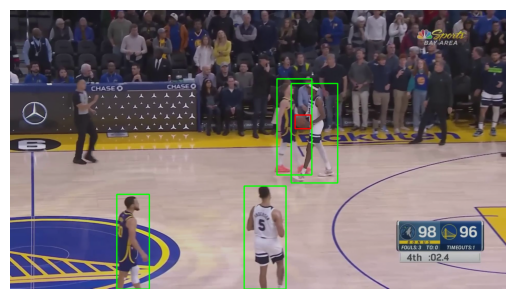

In [10]:
for i,(images, labels) in enumerate(trainloader):
    N = len(images)
    for j in range(N):
        image = images[j]       # (C, H, W) tensor float
        label = labels[j]       # dict with keys 'boxes', 'labels'        

vis_image = draw_gt_pred_boxes(image, label, None)
plt.imshow(vis_image)
plt.axis('off')

In [8]:
for (images, labels) in trainloader:
    predictions = model(images)
    N = len(images)
    for i in range(N):
        image = images[i]       # (C, H, W) tensor float
        label = labels[i]       # dict with keys 'boxes', 'labels'
        pred = predictions[i]   # dict with keys 'boxes', 'labels', 'scores'
    break

In [23]:
vis_image = draw_gt_pred_boxes(image, label, pred)

(-0.5, 1919.5, 1079.5, -0.5)

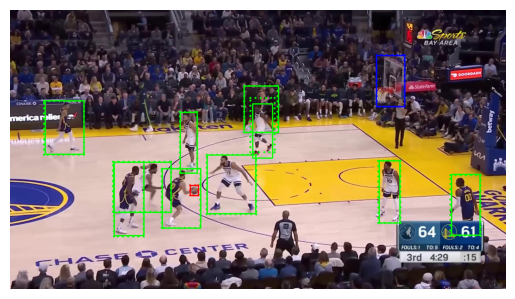

In [24]:
plt.imshow(vis_image)
plt.axis('off')